# Settings

## Constant

In [34]:
import pytz
import os


DEFAULT_TZ = pytz.FixedOffset(540)  # GMT+09:00; Asia/Seoul

PATH_DATA = '../data'
PATH_ESM = os.path.join(PATH_DATA, 'EsmResponse.csv')
PATH_PARTICIPANT = os.path.join(PATH_DATA, 'UserInfo.csv')
PATH_SENSOR = os.path.join(PATH_DATA, 'Sensor')

PATH_INTERMEDIATE = './intermediate'

DATA_TYPES = {
    'Acceleration': 'ACC',
    'AmbientLight': 'AML',
    'Calorie': 'CAL',
    'Distance': 'DST',
    'EDA': 'EDA',
    'HR': 'HRT',
    'RRI': 'RRI',
    'SkinTemperature': 'SKT',
    'StepCount': 'STP',
    'UltraViolet': 'ULV',
    'ActivityEvent': 'ACE',
    'ActivityTransition': 'ACT',
    'AppUsageEvent': 'APP',
    'BatteryEvent': 'BAT',
    'CallEvent': 'CAE',
    'Connectivity': 'CON',
    'DataTraffic': 'DAT',
    'InstalledApp': 'INS',
    'Location': 'LOC',
    'MediaEvent': 'MED',
    'MessageEvent': 'MSG',
    'WiFi': 'WIF',
    'ScreenEvent': 'SCR',
    'RingerModeEvent': 'RNG',
    'ChargeEvent': 'CHG',
    'PowerSaveEvent': 'PWS',
    'OnOffEvent': 'ONF'
}


## Utility Functions

In [97]:
import pandas as pd
import numpy as np
import scipy.stats as st
import cloudpickle
import ray
from datetime import datetime
from contextlib import contextmanager
import warnings
import time


def load(path: str):
    with open(path, mode='rb') as f:
        return cloudpickle.load(f)

    
def dump(obj, path: str):
    with open(path, mode='wb') as f:
        cloudpickle.dump(obj, f)
        
    
def log(msg: any):
    print('[{}] {}'.format(datetime.now().strftime('%y-%m-%d %H:%M:%S'), msg))


def summary(x):
    x = np.asarray(x)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        n = len(x)
        # Here, uppercase np.dtype.kind corresponds to non-numeric data.
        # Also, we view the boolean data as dichotomous categorical data.
        if x.dtype.kind.isupper() or x.dtype.kind == 'b': 
            cnt = pd.Series(x).value_counts(dropna=False)
            card = len(cnt)
            cnt = cnt[:20]                
            cnt_str = ', '.join([f'{u}:{c}' for u, c in zip(cnt.index, cnt)])
            if card > 30:
                cnt_str = f'{cnt_str}, ...'
            return {
                'n': n,
                'cardinality': card,
                'value_count': cnt_str
            }
        else: 
            x_nan = x[np.isnan(x)]
            x_norm = x[~np.isnan(x)]
            
            tot = np.sum(x_norm)
            m = np.mean(x_norm)
            me = np.median(x_norm)
            s = np.std(x_norm, ddof=1)
            l, u = np.min(x_norm), np.max(x)
            conf_l, conf_u = st.t.interval(0.95, len(x_norm) - 1, loc=m, scale=st.sem(x_norm))
            n_nan = len(x_nan)
            
            return {
                'n': n,
                'sum': tot,
                'mean': m,
                'SD': s,
                'med': me,
                'range': (l, u),
                'conf.': (conf_l, conf_u),
                'nan_count': n_nan
            }


@contextmanager
def on_ray(*args, **kwargs):
    try:
        if ray.is_initialized():
            ray.shutdown()
        ray.init(*args, **kwargs)
        yield None
    finally:
        ray.shutdown()

## Settings for R

In [36]:
%load_ext rpy2.ipython

In [37]:
%%R

library(tidyverse)
library(ggforce)
library(ggpubr)
library(showtext)
library(rmcorr)
library(patchwork)

font_add_google(
    name='Source Serif Pro',
    family='ssp',
    db_cache=FALSE
)

showtext_auto()

THEME_DEFAULT <- theme_bw(
    base_size=10,
    base_family='ssp',
) + theme(
        axis.title.x=element_text(colour='grey20', size=10, face='bold'),
        axis.title.y=element_text(colour='grey20', size=10, face='bold'),
        axis.text.x=element_text(colour='grey20', size=10),
        axis.text.y=element_text(colour='grey20', size=10),
        strip.text.x=element_text(colour='grey20', size=10, face='bold'),
        strip.text.y=element_text(colour='grey20', size=10, face='bold'),
        legend.background=element_blank(),
        legend.title=element_text(colour='grey20', size=10, face='bold'),
        legend.text=element_text(colour='grey20', size=10),
        legend.position='top',
        legend.box.spacing= unit(0, 'cm'),
        plot.subtitle=element_text(colour='grey20', size=10, hjust=.5),
    )


System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.0 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


R[write to console]: Loading required package: sysfonts

R[write to console]: Loading required package: showtextdb



# Dataset Overview

## Participants

In [98]:
import pandas as pd
import os


PARTICIPANTS = pd.read_csv(PATH_PARTICIPANT).set_index('pcode').assign(
    particpationStartDateTime=lambda x: pd.to_datetime(
        x['participationStartDate'], format='%Y-%m-%d'
    ).dt.tz_localize(DEFAULT_TZ)
)
PARTICIPANTS.head()

,participationStartDate,age,gender,openness,conscientiousness,neuroticism,extraversion,agreeableness,PSS,PHQ,GHQ,particpationStartDateTime
pcode,,,,,,,,,,,,
P01,2019-05-08,27,M,11,11,3,4,13,13,0,1,2019-05-08 00:00:00+09:00
P02,2019-05-08,21,M,14,5,12,14,5,27,6,18,2019-05-08 00:00:00+09:00
P03,2019-05-08,24,F,10,15,8,7,11,18,2,6,2019-05-08 00:00:00+09:00
P04,2019-05-08,23,M,12,11,8,6,11,20,1,9,2019-05-08 00:00:00+09:00
P05,2019-05-08,27,F,10,11,13,10,6,25,14,9,2019-05-08 00:00:00+09:00


Belows are some demographics:

In [99]:
for c in PARTICIPANTS.columns:
    print(f'- {c}:', summary(PARTICIPANTS[c]))

- participationStartDate: {'n': 77, 'cardinality': 3, 'value_count': '2019-05-08:27, 2019-05-16:25, 2019-04-30:25'}
- age: {'n': 77, 'sum': 1686, 'mean': 21.896103896103895, 'SD': 3.8613619617422406, 'med': 21.0, 'range': (17, 38), 'conf.': (21.019682236199852, 22.77252555600794), 'nan_count': 0}
- gender: {'n': 77, 'cardinality': 2, 'value_count': 'M:53, F:24'}
- openness: {'n': 77, 'sum': 787, 'mean': 10.220779220779221, 'SD': 2.8956563505732467, 'med': 11.0, 'range': (3, 15), 'conf.': (9.563545848092234, 10.878012593466208), 'nan_count': 0}
- conscientiousness: {'n': 77, 'sum': 820, 'mean': 10.64935064935065, 'SD': 2.3662441579221882, 'med': 11.0, 'range': (5, 15), 'conf.': (10.112279104861539, 11.18642219383976), 'nan_count': 0}
- neuroticism: {'n': 77, 'sum': 618, 'mean': 8.025974025974026, 'SD': 2.6900108881310953, 'med': 8.0, 'range': (3, 14), 'conf.': (7.4154164478204185, 8.636531604127633), 'nan_count': 0}
- extraversion: {'n': 77, 'sum': 703, 'mean': 9.12987012987013, 'SD': 3

## Labels (via ESM)

In [117]:
import pandas as pd
import os


LABELS = pd.read_csv(PATH_ESM).set_index(
    ['pcode']
)
LABELS.head()

,responseTime,scheduledTime,valence,arousal,attention,stress,duration,disturbance,change
pcode,,,,,,,,,
P01,1557278103000,NaN,0,0,0,-1,20.0,3,-2
P01,1557278986000,1.557279e+12,-3,3,3,3,5.0,-1,-3
P01,1557281772000,1.557282e+12,-3,-2,2,2,15.0,3,-2
P01,1557287138000,NaN,2,-1,2,0,15.0,1,-1
P01,1557291117000,NaN,3,3,3,-3,20.0,1,0


In [122]:
for c in LABELS.columns:
    print(f'- {c}:', summary(LABELS[c]))

- responseTime: {'n': 5582, 'sum': 8694314195328000, 'mean': 1557562557385.8833, 'SD': 590915040.4254278, 'med': 1557562969500.0, 'range': (1556582982000, 1558545246000), 'conf.': (1557547052362.8618, 1557578062408.9048), 'nan_count': 0}
- scheduledTime: {'n': 5582, 'sum': 5175814282500000.0, 'mean': 1557572760306.9517, 'SD': 591697484.8543198, 'med': 1557565860000.0, 'range': (1556586120000.0, nan), 'conf.': (1557552635074.4736, 1557592885539.4297), 'nan_count': 2259}
- valence: {'n': 5582, 'sum': 3665, 'mean': 0.6565747044070226, 'SD': 1.4184297545899174, 'med': 1.0, 'range': (-3, 3), 'conf.': (0.6193565182132938, 0.6937928906007513), 'nan_count': 0}
- arousal: {'n': 5582, 'sum': -529, 'mean': -0.09476890003582945, 'SD': 1.6675313128774563, 'med': 0.0, 'range': (-3, 3), 'conf.': (-0.13852326339835566, -0.051014536673303246), 'nan_count': 0}
- attention: {'n': 5582, 'sum': 2236, 'mean': 0.4005732712289502, 'SD': 1.6113242733571864, 'med': 1.0, 'range': (-3, 3), 'conf.': (0.35829372468

Belows are some demographics:

In [126]:
inst = LABELS.groupby('pcode').count().iloc[:, -1]
inst_sch = LABELS.loc[lambda x: ~x['scheduledTime'].isna(), :].groupby('pcode').count().iloc[:, -1]
inst_vol = LABELS.loc[lambda x: x['scheduledTime'].isna(), :].groupby('pcode').count().iloc[:, -1]
resp_time = LABELS.assign(
    timestamp=lambda x: pd.to_datetime(x['responseTime'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ)
)
sam = np.concatenate([
    (resp_time.loc[p, 'timestamp'].array - resp_time.loc[p, 'timestamp'].array.shift(1)).dropna().total_seconds()
    for p in LABELS.index.unique()
])

print('- # Inst.:', summary(inst))
print('- # Inst. - Scheduled:', summary(inst_sch))
print('- # Inst. - Voluntary:', summary(inst_vol))
print('- Samp. period:', summary(sam))
for c in LABELS.columns:
    print(f'- {c}:', summary(LABELS[c]))

- # Inst.: {'n': 77, 'sum': 5582, 'mean': 72.49350649350649, 'SD': 16.02270048911147, 'med': 74.0, 'range': (20, 110), 'conf.': (68.85679957559911, 76.13021341141386), 'nan_count': 0}
- # Inst. - Scheduled: {'n': 76, 'sum': 3323, 'mean': 43.723684210526315, 'SD': 19.36291898394835, 'med': 43.5, 'range': (3, 83), 'conf.': (39.29906768359284, 48.14830073745979), 'nan_count': 0}
- # Inst. - Voluntary: {'n': 77, 'sum': 2259, 'mean': 29.337662337662337, 'SD': 16.297893300742235, 'med': 27.0, 'range': (2, 74), 'conf.': (25.638494313245726, 33.03683036207895), 'nan_count': 0}
- Samp. period: {'n': 5505, 'sum': 42240670.0, 'mean': 7673.146230699364, 'SD': 13193.471538029606, 'med': 3090.0, 'range': (1.0, 136446.0), 'conf.': (7324.548923384188, 8021.743538014541), 'nan_count': 0}
- responseTime: {'n': 5582, 'sum': 8694314195328000, 'mean': 1557562557385.8833, 'SD': 590915040.4254278, 'med': 1557562969500.0, 'range': (1556582982000, 1558545246000), 'conf.': (1557547052362.8618, 1557578062408.904

### Plot

In [105]:
data = LABELS.loc[
    :, lambda x: ~x.columns.isin(['responseTime', 'scheduledTime'])
]

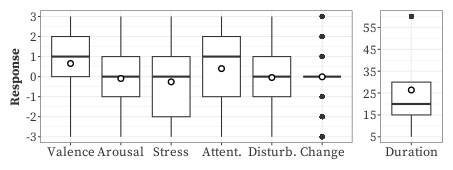

In [106]:
%%R -i data -w 16 -h 6 -u cm

data <- LABELS %>% pivot_longer(
    cols = c('valence', 'arousal', 'attention', 'stress', 'duration', 'disturbance', 'change'),
    names_to = 'metric'
)

p_rest <- ggplot(
    data %>% filter(metric != 'duration'), aes(x=metric, y=value)
) + geom_boxplot(
) + geom_point(
    data = data %>% filter(
        metric != 'duration'
    ) %>% group_by(
        metric
    ) %>% summarise(
        mean = mean(value, na.rm=TRUE)
    ),
    mapping=aes(x=metric, y=mean),
    shape=21,
    stroke=1,
    size=2,
    fill='white'
) + scale_x_discrete(
    name=NULL,
    limits=c('valence', 'arousal', 'stress', 'attention', 'disturbance', 'change'),
    labels=c('Valence', 'Arousal', 'Stress', 'Attent.', 'Disturb.', 'Change'),
) + scale_y_continuous(
    name='Response',
    breaks=-3:3
) + THEME_DEFAULT

p_duration <- ggplot(
    data %>% filter(metric == 'duration'), aes(x=metric, y=value)
) + geom_boxplot(
) + geom_point(
    data = data %>% filter(
        metric == 'duration'
    ) %>% group_by(
        metric
    ) %>% summarise(
        mean = mean(value, na.rm=TRUE)
    ),
    mapping=aes(x=metric, y=mean),
    shape=21,
    stroke=1,
    size=2,
    fill='white'
)+ scale_x_discrete(
    name=NULL,
    limits=c('duration'),
    labels=c('Duration'),
) + scale_y_continuous(
    name=NULL,
    breaks=seq(from=5, to=60, by=10)
) + THEME_DEFAULT

p <- p_rest + p_duration + plot_layout(widths=c(4, 0.8))
ggsave('./fig/dist-labels.pdf', plot=p, width=16, height=6, unit='cm', device=cairo_pdf)
print(p)

### Correlation

Because each participant reported their labels multiple times (i.e., repeated measure), repeated measure correlation between affect labels were used.

In [108]:
data = LABELS.reset_index()[[
    'pcode', 'valence', 'arousal', 'stress', 'attention', 'disturbance', 'change'
]]

In [109]:
%%R -i data 

com <- combn(c('valence', 'arousal', 'stress', 'attention', 'disturbance', 'change'), 2)

for(i in 1:ncol(com)) {
    a <- com[, i][1]
    b <- com[, i][2]
    r <- rmcorr(participant = 'pcode', measure1=a, measure2=b, dataset=data)
    cat(a, '-', b, ': R =', r$r, '(p =', r$p, ') \n')
}

valence - arousal : R = 0.3858505 (p = 6.005105e-195 ) 
valence - stress : R = -0.5918317 (p = 0 ) 
valence - attention : R = 0.2880379 (p = 1.138238e-105 ) 
valence - disturbance : R = -0.02946216 (p = 0.02880521 ) 
valence - change : R = 0.3163849 (p = 2.978458e-128 ) 
arousal - stress : R = -0.2020498 (p = 8.095612e-52 ) 
arousal - attention : R = 0.4354836 (p = 1.162341e-253 ) 
arousal - disturbance : R = 0.0284022 (p = 0.03507786 ) 
arousal - change : R = 0.1673468 (p = 7.1899e-36 ) 
stress - attention : R = -0.1515681 (p = 1.176714e-29 ) 
stress - disturbance : R = 0.08679844 (p = 1.108432e-10 ) 
stress - change : R = -0.2907816 (p = 9.560751e-108 ) 
attention - disturbance : R = 0.1182107 (p = 1.363257e-18 ) 
attention - change : R = 0.1163492 (p = 4.682081e-18 ) 
disturbance - change : R = -0.2216444 (p = 3.009815e-62 ) 


## Sensor Data

In [110]:
import os
import pandas as pd
from typing import Optional


def _load_data(
    name: str
) -> Optional[pd.DataFrame]:
    paths = [
        (d, os.path.join(PATH_SENSOR, d, f'{name}.csv'))
        for d in os.listdir(PATH_SENSOR)
        if d.startswith('P')
    ]
    return pd.concat(
        filter(
            lambda x: len(x.index), 
            [
                pd.read_csv(p).assign(pcode=pcode)
                for pcode, p in paths
                if os.path.exists(p)
            ]
        ), ignore_index=True
    ).assign(
        timestamp=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ)
    ).set_index(
        ['pcode', 'timestamp']
    )

In [30]:
import pandas as pd
import gc
from datetime import timedelta as td


STATS = []

for data_type in DATA_TYPES:
    dat = _load_data(data_type)
    inst = dat.groupby('pcode').count().iloc[:, -1]
    samp = np.concatenate([
        (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()
        for p in dat.index.get_level_values('pcode').unique()
    ])
    inst, samp = summary(inst), summary(samp)
    
    print('#'*5, data_type, '#'*5)
    print('- # Inst.:', inst)
    print('- Samp. period:', samp)
    
    for c in dat.columns:
        print(f'- {c}:', summary(dat[c]))
        
    del dat
    gc.collect()
    
STATS = pd.DataFrame(STATS)

##### Acceleration #####
- # Inst.: {'n': 77, 'mean': 1600779.2337662338, 'SD': 473426.34254662704, 'med': 1616756.0, 'range': (489289, 2464554), 'conf.': (1493324.634822134, 1708233.8327103336), 'nan_count': 0}
- Samp. period: {'n': 123259924, 'mean': 0.33436376868121337, 'SD': 113.32762322571338, 'med': 0.13, 'range': (0.001, 347544.66), 'conf.': (0.3143571853179482, 0.35437035204447853), 'nan_count': 0}
- x: {'n': 123260001, 'mean': -0.048675041780067936, 'SD': 0.6191499890392023, 'med': -0.066162109375, 'range': (-7.9951171875, 7.99975585938), 'conf.': (-0.04878434498125066, -0.048565738578885215), 'nan_count': 0}
- y: {'n': 123260001, 'mean': 0.17742617406616976, 'SD': 0.5751403091314409, 'med': 0.223876953125, 'range': (-7.9951171875, 7.9990234375), 'conf.': (0.17732464022456404, 0.17752770790777547), 'nan_count': 0}
- z: {'n': 123260001, 'mean': 0.2249011998856201, 'SD': 0.5024588858345705, 'med': 0.2138671875, 'range': (-8.0, 7.9990234375), 'conf.': (0.2248124970419527, 0.22498

# Preprocessing

## Label

Because we intended to collected participants' responses to ESMs not voluntary responses, we screend out some responses as follows:
* We first screen out ESM responses that does not have 'scheduledTime' (meaning that a given ESM was expired or participants voluntarily reported their affective states regardless of ESM delivery). 
* Since we will evaluate our model using LOSO, the small number of responses for each participant might lead to inappropriate performance evaluation. We emprically set the number of the minimum responses upon ESM delivery as 5 per day (i.e., a half of our guides), so that we excluded participants whose responses to ESM less than 35.

In [113]:
LABELS_VALID = LABELS.loc[
    lambda x: ~x['scheduledTime'].isna(), :
]
print(f'# Non-voluntary response: {len(LABELS_VALID)}')
print(summary(LABELS_VALID.groupby('pcode').count().iloc[:, -1]))

excl_pcode = LABELS_VALID.loc[
    lambda x: ~x['scheduledTime'].isna()
].groupby('pcode').count().iloc[:, -1].loc[lambda y: y < 35]

LABELS_VALID = LABELS_VALID.loc[
    lambda x:  ~x.index.get_level_values('pcode').isin(excl_pcode.index), :
]
print(f'# Response from participants with enough responses: {len(LABELS_VALID)}')
print(summary(LABELS_VALID.groupby('pcode').count().iloc[:, -1]))

print('# Participants whose responses to ESM delivery were less then 35')
print(excl_pcode, f'#participants = {len(excl_pcode)} / #response = {sum(excl_pcode)}')

# Non-voluntary response: 3323
{'n': 76, 'sum': 3323, 'mean': 43.723684210526315, 'SD': 19.36291898394835, 'med': 43.5, 'range': (3, 83), 'conf.': (39.29906768359284, 48.14830073745979), 'nan_count': 0}
# Response from participants with enough responses: 2619
{'n': 47, 'sum': 2619, 'mean': 55.723404255319146, 'SD': 13.076201628480542, 'med': 52.0, 'range': (36, 83), 'conf.': (51.88408763344431, 59.56272087719398), 'nan_count': 0}
# Participants whose responses to ESM delivery were less then 35
pcode
P04    34
P07    24
P11    22
P14    11
P16    30
P17    13
P18    32
P20    31
P22    23
P24    10
P25    30
P29    32
P34    22
P36    29
P37    31
P38    33
P41    31
P43    24
P44    23
P46     4
P54    13
P56    31
P58    29
P62     3
P63    34
P64    30
P68    11
P73    31
P74    33
Name: change, dtype: int64 #participants = 29 / #response = 704


Here we consider binary classifications for valence, arousal, stress, and disturbance, in which a label value greater than 0 is "HIGH" (1) and the rest is "LOW" (0), at the arrival of ESM prompts (*scheduledTime*)

In [134]:
import pandas as pd
import numpy as np


LABELS_PROC = LABELS_VALID.reset_index().assign(
    timestamp=lambda x: pd.to_datetime(x['scheduledTime'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ),
    valence_bin = lambda x: np.where(x['valence'] > 0, 1, 0),
    arousal_bin = lambda x: np.where(x['arousal'] > 0, 1, 0),
    stress_bin = lambda x: np.where(x['stress'] > 0, 1, 0),
    disturbance_bin = lambda x: np.where(x['disturbance'] > 0, 1, 0)
).set_index(
    ['pcode', 'timestamp']
)

LABELS_PROC.head()

responseTime  scheduledTime  valence  \
pcode timestamp                                                          
P01   2019-05-08 10:26:00+09:00  1557278986000   1.557279e+12       -3   
      2019-05-08 11:13:00+09:00  1557281772000   1.557282e+12       -3   
      2019-05-08 15:56:00+09:00  1557298702000   1.557299e+12        3   
      2019-05-08 16:41:00+09:00  1557301311000   1.557301e+12        3   
      2019-05-08 17:23:00+09:00  1557304062000   1.557304e+12        3   

                                 arousal  attention  stress  duration  \
pcode timestamp                                                         
P01   2019-05-08 10:26:00+09:00        3          3       3       5.0   
      2019-05-08 11:13:00+09:00       -2          2       2      15.0   
      2019-05-08 15:56:00+09:00        3          3      -3      20.0   
      2019-05-08 16:41:00+09:00        3          3      -3      30.0   
      2019-05-08 17:23:00+09:00        3          3      -3      20.0   

                                 disturbance  change  valence_bin  \
pcode timestamp                                                     
P01   2019-05-08 10:26:00+09:00           -1      -3            0   
      2019-05-08 11:13:00+09:00            3      -2            0   
      2019-05-08 15:56:00+09:00            2       0            1   
      2019-05-08 16:41:00+09:00            1       2            1   
      2019-05-08 17:23:00+09:00            2       2            1   

                                 arousal_bin  stress_bin  disturbance_bin  
pcode timestamp                                                            
P01   2019-05-08 10:26:00+09:00            1           1                0  
      2019-05-08 11:13:00+09:00            0           1                1  
      2019-05-08 15:56:00+09:00            1           0                1  
      2019-05-08 16:41:00+09:00            1           0                1  
      2019-05-08 17:23:00+09:00            1           0                1

In [131]:
import numpy as np


inst = LABELS_PROC.groupby('pcode').count().iloc[:, -1]
for c in [c for c in LABELS_PROC.columns if c.endswith('_bin')]:
    print(f'- {c}:', summary(LABELS_PROC[c].astype(object)))

- valence_bin: {'n': 2619, 'cardinality': 2, 'value_count': '1:1556, 0:1063'}
- arousal_bin: {'n': 2619, 'cardinality': 2, 'value_count': '0:1586, 1:1033'}
- stress_bin: {'n': 2619, 'cardinality': 2, 'value_count': '0:1702, 1:917'}
- disturbance_bin: {'n': 2619, 'cardinality': 2, 'value_count': '0:1509, 1:1110'}


## Sensor Data

For each type of sensor data, we applied different preprocessing. Detailed decsription is provided in the paper.



### Implementation

In [10]:
import pandas as pd
import numpy as np
import scipy.spatial.distance as dist
from typing import Dict, Union
import pygeohash as geo
from datetime import timedelta
from collections import defaultdict


# AppUsageEvent.csv
def _proc_app_usage(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    data = data.loc[
        lambda x: x['type'].isin(['MOVE_TO_FOREGROUND', 'MOVE_TO_BACKGROUND']), :
    ].assign(
        packageName=lambda x: np.where(x['type'] == 'MOVE_TO_FOREGROUND', x['packageName'], None),
        category=lambda x: np.where(x['type'] == 'MOVE_TO_FOREGROUND', x['category'], None),
    )

    return {
        'PAC': data['packageName'].astype('object'),
        'CAT': data['category'].astype('object')
    }


# Connectivity.csv
def _proc_connectivity(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    data = data.assign(
        type=lambda x: np.where(x['isConnected'] == True, x['type'], 'DISCONNECTED')
    )

    return data['type'].astype('object')


# BatteryEvent.csv
def _proc_battery(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return {
        'LEV': data['level'].astype('float32'),
        'STA': data['status'].astype('object'),
        'TMP': data['temperature'].astype('float32')
    }
        

# CallEvent.csv
def _proc_call(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    data = data.loc[
        lambda x: x['duration'] > 0, :
    ]
    new_data = []

    for row in data.itertuples():
        pcode, timestamp = row.Index
        
        new_data.append({
            'pcode': pcode,
            'timestamp': timestamp,                
            'state': 'CALL',
        })
        new_data.append({
            'pcode': pcode,
            'timestamp': timestamp + timedelta(milliseconds=row.duration),
            'state': 'IDLE'
        })

    new_data = pd.DataFrame(new_data).set_index(
        ['pcode', 'timestamp']
    )

    return new_data['state'].astype('object')


# DataTraffic.csv
def _proc_data_traffic(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return {
        'RCV': data['rxKiloBytes'].astype('float32'),
        'SNT': data['txKiloBytes'].astype('float32')
    }


# RingerModeEvent.csv
def _proc_ringer_mode(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['type'].astype('object')


# ScreenEvent.csv
def _proc_screen(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['type'].astype('object')


# OnOffEvent.csv
def _proc_on_off(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['type'].astype('object')


# PowerSaveEvent.csv
def _proc_power_save(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['type'].astype('object')


# ChargeEvent.csv
def _proc_charge(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['type'].astype('object')


# Location.csv
def _proc_location(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    def _haversine(_lat1, _lat2, _lng1, _lng2) -> float:
        if np.isnan(_lat1) or np.isnan(_lat2) or np.isnan(_lng1) or np.isnan(_lng2):
            return 0.0

        _lat1_r, _lat2_r, _lng1_r, _lng2_r = np.radians(_lat1), np.radians(_lat2), np.radians(_lng1), np.radians(_lng2)
        _lat = _lat2_r - _lat1_r
        _lng = _lng2_r - _lng1_r
        _R = 6371008.8
        _d = np.sin(_lat * 0.5) ** 2 + np.cos(_lat1_r) * np.cos(_lat2_r) * np.sin(_lng * 0.5) ** 2
        return 2 * _R * np.arcsin(np.sqrt(_d))

    new_data = []
    
    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        ).assign(
            _latitude=lambda x: x['latitude'].shift(1),
            _longitude=lambda x: x['longitude'].shift(1),
            dist=lambda x: x.apply(
                lambda y: _haversine(y['latitude'], y['_latitude'], y['longitude'], y['_longitude']),
                axis=1
            ),
            cluster=lambda x: x.apply(
                lambda y: geo.encode(y['latitude'], y['longitude'], precision=7),
                axis=1
            ),
            pcode=pcode
        ).reset_index()
        new_data.append(sub)

    new_data = pd.concat(new_data, axis=0, ignore_index=True).set_index(
        ['pcode', 'timestamp']
    )

    return {
        'CLS': new_data['cluster'].astype('object'),
        'DST': new_data['dist'].astype('float32')
    }


# ActivityEvent.csv
def _proc_activity_event(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return {
        'UNK': data['confidenceUnknown'].astype('float32'),
        'FOT': data['confidenceOnFoot'].astype('float32'),
        'WLK': data['confidenceWalking'].astype('float32'),
        'VHC': data['confidenceInVehicle'].astype('float32'),
        'BCC': data['confidenceOnBicycle'].astype('float32'),
        'RUN': data['confidenceRunning'].astype('float32'),
        'TLT': data['confidenceTilting'].astype('float32')
    }


# ActivityTransition.csv
def _proc_activity_transition(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    data = data.loc[
        lambda x: x['transitionType'].isin(['ENTER_WALKING', 'ENTER_STILL', 'ENTER_IN_VEHICLE', 'ENTER_ON_BICYCLE', 'ENTER_RUNNING']), :
    ].assign(
        type=lambda x: x['transitionType'].str.replace('ENTER_', '')
    )
    
    return data['type'].astype('object')


# WiFi.csv
def _proc_wifi(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = []
    
    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        ).assign(
            bssid=lambda x: x['bssid'].str.cat(x['frequency'].astype(str), sep='-')
        )
        t = sub.index.unique().array
        for cur_t, prev_t in zip(t, t.shift(1)):
            if cur_t is pd.NaT or prev_t is pd.NaT:
                continue

            prev = sub.loc[[prev_t], :]
            cur = sub.loc[[cur_t], :]
            intersect = np.intersect1d(prev['bssid'], cur['bssid'])
            union = np.union1d(prev['bssid'], cur['bssid'])
            w = np.repeat(1 / len(intersect), len(intersect)) if len(intersect) else 1.0
            prev_intersect = prev.loc[
                lambda x: x['bssid'].isin(intersect), :
            ].sort_values('bssid')
            cur_intersect = cur.loc[
                lambda x: x['bssid'].isin(intersect), :
            ].sort_values('bssid')
            prev_rssi = prev_intersect['rssi']
            cur_rssi = cur_intersect['rssi']

            new_data.append(dict(
                pcode=pcode,
                timestamp=cur_t,
                cosine=1 - dist.cosine(prev_rssi, cur_rssi) if len(intersect) > 0 else 0,
                euclidean=1 / (1 + dist.euclidean(prev_rssi, cur_rssi, w)) if len(intersect) > 0 else 0,
                manhattan=1 / (1 + dist.cityblock(prev_rssi, cur_rssi, w)) if len(intersect) > 0 else 0,
                jaccard = len(intersect) / len(union) if len(union) > 0 else 0
            ))
            
    new_data = pd.DataFrame(new_data).set_index(
        ['pcode', 'timestamp']
    )
    
    return {
        'COS': new_data['cosine'].astype('float32'),
        'EUC': new_data['euclidean'].astype('float32'),
        'MAN': new_data['manhattan'].astype('float32'),
        'JAC': new_data['jaccard'].astype('float32')
    }


# InstalledApp.csv
def _proc_installed_app(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = []
    
    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(axis=0, level='timestamp')
        t = sub.index.unique().array
        for cur_t, prev_t in zip(t, t.shift(1)):
            if cur_t is pd.NaT or prev_t is pd.NaT:
                continue

            prev = sub.loc[[prev_t], :]
            cur = sub.loc[[cur_t], :]
            intersect = np.intersect1d(prev['packageName'], cur['packageName'])
            union = np.union1d(prev['packageName'], cur['packageName'])
            new_data.append(dict(
                pcode=pcode,
                timestamp=cur_t,
                jaccard = len(intersect) / len(union) if len(union) > 0 else 0
            ))
            
    new_data = pd.DataFrame(new_data).set_index(
        ['pcode', 'timestamp']
    )
    
    return {
       'JAC': new_data['jaccard'].astype('float32')
    }


# MediaEvent.csv
def _proc_media_event(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = defaultdict(list)
    
    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        )

        video = sub.loc[
            lambda x: x['mimetype'].str.startswith('video'), :
        ].assign(
            event=1,
            pcode=pcode
        ).reset_index()

        image = sub.loc[
            lambda x: x['mimetype'].str.startswith('image'), :
        ].assign(
            event=1,
            pcode=pcode
        ).reset_index()

        media = sub.assign(
            event=1,
            pcode=pcode
        ).reset_index()

        new_data['VID'].append(video)
        new_data['IMG'].append(image)
        new_data['ALL'].append(media)

    return {
        k: pd.concat(
            v, axis=0, ignore_index=True
        ).set_index(
            ['pcode', 'timestamp']
        )['event'].astype('float32') 
        for k, v in new_data.items()
    }


# MessageEvent.csv
def _proc_message_event(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = defaultdict(list)
    
    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        )

        sent = sub.loc[
            lambda x: x['messageBox'] == 'SENT', :
        ].assign(
            event=1,
            pcode=pcode
        ).reset_index()

        recv = sub.loc[
            lambda x: x['messageBox'] == 'INBOX', :
        ].assign(
            event=1,
            pcode=pcode
        ).reset_index()

        msg = sub.assign(
            event=1,
            pcode=pcode
        ).reset_index()

        new_data['SNT'].append(sent)
        new_data['RCV'].append(recv)
        new_data['ALL'].append(msg)

    return {
        k: pd.concat(
            v, axis=0, ignore_index=True
        ).set_index(
            ['pcode', 'timestamp']
        )['event'].astype('float32') 
        for k, v in new_data.items()
    }


# Acceleration.csv
def _proc_acceleration(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    data = data.assign(
        mag=lambda x: np.sqrt(np.square(x['x']) + np.square(x['y']) + np.square(x['z']))
    )

    return {
        'AXX': data['x'].astype('float32'),
        'AXY': data['y'].astype('float32'),
        'AXZ': data['z'].astype('float32'),
        'MAG': data['mag'].astype('float32')
    }

# UltraViolet.csv
def _proc_ultra_violet(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = []
    
    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        ).assign(
            exposure=lambda x: (x['totalExposure'] - x['totalExposure'].shift(1)),
            pcode=pcode
        ).reset_index()

        new_data.append(sub)

    new_data = pd.concat(new_data, axis=0, ignore_index=True).set_index(
        ['pcode', 'timestamp']
    )

    return {
        'INT': new_data['intensity'].astype('object'),
        'EXP': new_data['exposure'].dropna().astype('float32')
    }


# SkinTemperature.csv
def _proc_skin_temperature(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['temperature'].astype('float32')


# RRI.csv
def _proc_rri(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['interval'].astype('float32')


# AmbientLight.csv
def _proc_ambient_light(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['brightness'].astype('float32')
    

# StepCount.csv
def _proc_step_count(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = []

    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        ).assign(
            steps=lambda x: (x['totalSteps'] - x['totalSteps'].shift(1)),
            pcode=pcode
        ).reset_index()
        new_data.append(sub)

    new_data = pd.concat(new_data, axis=0, ignore_index=True).set_index(
        ['pcode', 'timestamp']
    )

    return new_data['steps'].dropna().astype('float32')
    

# HR.csv
def _proc_hr(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['bpm'].astype('float32')
    

# EDA.csv
def _proc_eda(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['resistance'].astype('float32')


# Distance.csv
def _proc_distance(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = []

    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        ).assign(
            distance=lambda x: x['totalDistance'] - x['totalDistance'].shift(1),
            pcode=pcode
        ).reset_index()

        new_data.append(sub)

    new_data = pd.concat(new_data, axis=0, ignore_index=True).set_index(
        ['pcode', 'timestamp']
    )

    return {
        'DST': new_data['distance'].dropna().astype('float32'),
        'MOT': new_data['motionType'].astype('object'),
        'PAC': new_data['pace'].astype('float32'),
        'SPD': new_data['speed'].astype('float32')
    }


# Calorie.csv
def _proc_calories(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = []

    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        ).assign(
            calories=lambda x: x['totalCalories'] - x['totalCalories'].shift(1),
            pcode=pcode
        ).reset_index()

        new_data.append(sub)

    new_data = pd.concat(new_data, axis=0, ignore_index=True).set_index(
        ['pcode', 'timestamp']
    )

    return new_data['calories'].dropna().astype('float32')           


### Execution

In [23]:
import pandas as pd
import gc
from functools import reduce

FUNC_PROC = {
    'Acceleration': _proc_acceleration,
    'AmbientLight': _proc_ambient_light,
    'Calorie': _proc_calories,
    'Distance': _proc_distance,
    'EDA': _proc_eda,
    'HR': _proc_hr,
    'RRI': _proc_rri,
    'SkinTemperature': _proc_skin_temperature,
    'StepCount': _proc_step_count,
    'UltraViolet': _proc_ultra_violet,
    'ActivityEvent': _proc_activity_event,
    'ActivityTransition': _proc_activity_transition,
    'AppUsageEvent': _proc_app_usage,
    'BatteryEvent': _proc_battery,
    'CallEvent': _proc_call,
    'Connectivity': _proc_connectivity,
    'DataTraffic': _proc_data_traffic,
    'InstalledApp': _proc_installed_app,
    'Location': _proc_location,
    'MediaEvent': _proc_media_event,
    'MessageEvent': _proc_message_event,
    'WiFi': _proc_wifi,
    'ScreenEvent': _proc_screen,
    'RingerModeEvent': _proc_ringer_mode,
    'ChargeEvent': _proc_charge,
    'PowerSaveEvent': _proc_power_save,
    'OnOffEvent': _proc_on_off
}


def _process(data_type: str):
    log(f'Begin to processing data: {data_type}')
    
    abbrev = DATA_TYPES[data_type]
    data_raw = _load_data(data_type)
    data_proc = FUNC_PROC[data_type](data_raw)
    result = dict()
    
    if type(data_proc) is dict:
        for k, v in data_proc.items():
            result[f'{abbrev}_{k}'] = v
    else:
        result[abbrev] = data_proc
        
    log(f'Complete processing data: {data_type}')
    return result



with on_ray(num_cpus=12):
    jobs = []
    
    func = ray.remote(_process).remote
    
    for data_type in DATA_TYPES:
        job = func(data_type)
        jobs.append(job)

    jobs = ray.get(jobs)
    jobs = reduce(lambda a, b: {**a, **b}, jobs)
    dump(jobs, os.path.join(PATH_INTERMEDIATE, 'proc.pkl'))

    del jobs
    gc.collect()

2023-03-14 16:54:32,379	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(_process pid=469) [23-03-14 16:54:33] Begin to processing data: SkinTemperature
(_process pid=463) [23-03-14 16:54:33] Begin to processing data: Distance
(_process pid=465) [23-03-14 16:54:33] Begin to processing data: AmbientLight
(_process pid=468) [23-03-14 16:54:33] Begin to processing data: Calorie
(_process pid=462) [23-03-14 16:54:33] Begin to processing data: RRI
(_process pid=464) [23-03-14 16:54:33] Begin to processing data: Acceleration
(_process pid=466) [23-03-14 16:54:33] Begin to processing data: EDA
(_process pid=467) [23-03-14 16:54:33] Begin to processing data: HR
(_process pid=469) [23-03-14 16:54:34] Complete processing data: SkinTemperature
(_process pid=469) [23-03-14 16:54:34] Begin to processing data: StepCount
(_process pid=467) [23-03-14 16:54:53] Complete processing data: HR
(_process pid=467) [23-03-14 16:54:53] Begin to processing data: UltraViolet
(_process pid=467) [23-03-14 16:54:55] Complete processing data: UltraViolet
(_process pid=467) [23-03-14 16:

In [84]:
import os
import gc


DATA = load(os.path.join(PATH_INTERMEDIATE, 'proc.pkl'))
N_NUMERIC, N_CATEGORICAL = 0, 0

for k, v in DATA.items():
    if v.dtype.kind.isupper() or v.dtype.kind == 'b': 
        N_CATEGORICAL = N_CATEGORICAL + 1
    else:
        N_NUMERIC = N_NUMERIC + 1
        
    inst = v.groupby('pcode').count()
    sam = np.concatenate([
        (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
        for p in v.index.get_level_values('pcode').unique()
    ])
    
    print('#'*5, k, '#'*5, )
    print('- # Inst.:', summary(inst))
    print('- Samp. period:', summary(sam))
    print('- Values', summary(v))
    print('')
    
    
print(f'# categorical data: {N_CATEGORICAL}/# numeric data: {N_NUMERIC}')
del DATA
gc.collect()

##### ACC_AXX #####
- # Inst.: {'n': 77, 'mean': 1600779.2337662338, 'SD': 473426.34254662704, 'med': 1616756.0, 'range': (489289, 2464554), 'conf.': (1493324.634822134, 1708233.8327103336), 'nan_count': 0}
- Samp. period: {'n': 123259924, 'mean': 0.33436376868121337, 'SD': 113.32762322571338, 'med': 0.13, 'range': (0.001, 347544.66), 'conf.': (0.3143571853179482, 0.35437035204447853), 'nan_count': 0}
- Values {'n': 123260001, 'mean': -0.048675075, 'SD': 0.61914885, 'med': -0.06616211, 'range': (-7.995117, 7.999756), 'conf.': (-0.04878437817355541, -0.04856577217320057), 'nan_count': 0}

##### ACC_AXY #####
- # Inst.: {'n': 77, 'mean': 1600779.2337662338, 'SD': 473426.34254662704, 'med': 1616756.0, 'range': (489289, 2464554), 'conf.': (1493324.634822134, 1708233.8327103336), 'nan_count': 0}
- Samp. period: {'n': 123259924, 'mean': 0.33436376868121337, 'SD': 113.32762322571338, 'med': 0.13, 'range': (0.001, 347544.66), 'conf.': (0.3143571853179482, 0.35437035204447853), 'nan_count': 0}


1201

# Feature Extraction

## Implementation

In [135]:
import numpy as np
import pandas as pd
from typing import Dict, Callable, Union, Tuple, List, Optional, Iterable
from datetime import timedelta as td
from scipy import stats
import ray
import warnings
import time


def _safe_na_check(_v):
    _is_nan_inf = False
    
    try:
        _is_nan_inf = np.isnan(_v) or np.isinf(_v)
    except:
        _is_nan_inf = False
    
    return _is_nan_inf or _v is None

            
def _extract(
        pid: str,
        data: Dict[str, pd.Series],
        label: pd.Series,
        label_values: List[str],
        window_data: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],
        window_label: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],        
        categories: Dict[str, Optional[List[any]]] = None,        
        constant_features: Dict[str, any] = None,
        resample_s: Dict[str, float] = None
) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    _s = time.time()
    log(f"Begin feature extraction on {pid}'s data.")

    categories = categories or dict()
    constant_features = constant_features or dict()
    resample_s = resample_s or dict()

    X, y, date_times = [], [], []
 
    for timestamp in label.index:
        row = dict()

        label_cur = label.at[timestamp]
        t = timestamp - td(milliseconds=1)

        # Features relevant to participants' info
        for d_key, d_val in constant_features.items():
            row[d_key] = d_val
        
        # Features from sensor data
        for d_key, d_val in data.items():
            is_numeric = d_key not in categories
            cats = categories.get(d_key) or list()
            d_val = d_val.sort_index()

            # Features relevant to latest value of a given data
            # These features are extracted only for bounded categorical data and numerical data.
            if is_numeric or cats:
                try:
                    v = d_val.loc[:t].iloc[-1]
                except (KeyError, IndexError):
                    v = 0

                if is_numeric:
                    row[f'{d_key}#VAL'] = v
                else:
                    for c in cats:
                        row[f'{d_key}#VAL={c}'] = v == c
            # Features relevant to duration since the latest state change.
            # These features are only for categorical data.
            # In addition, duration since a given state is set recently is considered, 
            # that are available only at bounded categorical data.
            if not is_numeric:
                try:
                    v = d_val.loc[:t]
                    row[f'{d_key}#DSC'] = (t - v.index[-1]).total_seconds() if len(v) else -1.0
                    for c in cats:
                        v_sub = v.loc[lambda x: x == c].index
                        row[f'{d_key}#DSC={c}'] = (t - v_sub[-1]).total_seconds() if len(v_sub) else -1.0
                except (KeyError, IndexError):
                    row[f'{d_key}#DSC'] = -1.0
                    for c in cats:
                        row[f'{d_key}#DSC={c}'] = -1.0

            # Features extracted from time-windows
            # These features requires resampling and imputation on each data.
            sample_rate = resample_s.get(d_key) or 1
            d_val_res = d_val.resample(f'{sample_rate}S', origin='start')
            if is_numeric:
                d_val_res = d_val_res.mean().interpolate(method='linear').dropna()
            else:
                d_val_res = d_val_res.ffill().dropna()
                
            for w_key, w_val in window_data.items():
                w_val = w_val(t) if isinstance(w_val, Callable) else w_val
                try:
                    v = d_val_res.loc[t - td(seconds=w_val):t]
                except (KeyError, IndexError):
                    continue
                
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')

                    if is_numeric:
                        hist, _ = np.histogram(v, bins='doane', density=False)
                        std = np.sqrt(np.var(v, ddof=1)) if len(v) > 1 else 0
                        v_norm = (v - np.mean(v)) / std if std != 0 else np.zeros(len(v))

                        row[f'{d_key}#AVG#{w_key}'] = np.mean(v) # Sample mean
                        row[f'{d_key}#STD#{w_key}'] = std # Sample standard deviation
                        row[f'{d_key}#SKW#{w_key}'] = stats.skew(v, bias=False) # Sample skewness
                        row[f'{d_key}#KUR#{w_key}'] = stats.kurtosis(v, bias=False) # Sample kurtosis
                        row[f'{d_key}#ASC#{w_key}'] = np.sum(np.abs(np.diff(v))) # Abstract sum of changes
                        row[f'{d_key}#BEP#{w_key}'] = stats.entropy(hist) # Binned entropy
                        row[f'{d_key}#MED#{w_key}'] = np.median(v) # Median
                        row[f'{d_key}#TSC#{w_key}'] = np.sqrt(np.sum(np.power(np.diff(v_norm), 2))) # Timeseries complexity
                    else:
                        cnt = v.value_counts()
                        val, sup = cnt.index, cnt.values
                        hist = {k: v for k, v in zip(val, sup)}
                        
                        # Information Entropy
                        row[f'{d_key}#ETP#{w_key}'] = stats.entropy(sup / len(v))
                        
                        # Abs. Sum of Changes
                        row[f'{d_key}#ASC#{w_key}'] = np.sum(v.values[1:] != v.values[:-1]) 

                        if len(cats) == 2: # Dichotomous categorical data
                            c = cats[0]
                            row[f'{d_key}#DUR#{w_key}'] = hist[c] / len(v) if c in hist else 0
                        else:
                            for c in cats:
                                row[f'{d_key}#DUR={c}#{w_key}'] = hist[c] / len(v) if c in hist else 0
        
        # Features relevant to time
        day_of_week = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'][t.isoweekday() - 1]
        is_weekend = 'Y' if t.isoweekday() > 5 else 'N'
        hour = t.hour

        if 6 <= hour < 9:
            hour_name = 'DAWN'
        elif 9 <= hour < 12:
            hour_name = 'MORNING'
        elif 12 <= hour < 15:
            hour_name = 'AFTERNOON'
        elif 15 <= hour < 18:
            hour_name = 'LATE_AFTERNOON'
        elif 18 <= hour < 21:
            hour_name = 'EVENING'
        elif 21 <= hour < 24:
            hour_name = 'NIGHT'
        else:
            hour_name = 'MIDNIGHT'
        
        for d in ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']:
            row[f'ESM#DOW={d}'] = d == day_of_week

        for d in ['Y', 'N']:
            row[f'ESM#WKD={d}'] = d == is_weekend
        
        for d in ['DAWN', 'MORNING', 'AFTERNOON', 'LATE_AFTERNOON', 'EVENING', 'NIGHT', 'MIDNIGHT']:
            row[f'ESM#HRN={d}'] = d == hour_name
        
        # Features extracted from previous respones behavior
        for w_key, w_val in window_label.items():
            w_val = w_val(t) if isinstance(w_val, Callable) else w_val

            try:
                v = label.loc[t - td(seconds=w_val):t]

                if len(label_values) <= 2: # Binary classification
                    row[f'ESM#LIK#{w_key}'] = np.sum(v == label_values[0]) / len(v) if len(v) > 0 else 0
                else:
                    for l in label_values:
                        row[f'ESM#LIK={l}#{w_key}'] = np.sum(v == l) / len(v) if len(v) > 0 else 0
            except (KeyError, IndexError):
                if len(label_values) <= 2: 
                    row[f'ESM#LIK#{w_key}'] = 0
                else:
                    for l in label_values:
                        row[f'ESM#LIK={l}#{w_key}'] = 0
        row = {
            k: 0.0 if _safe_na_check(v) else v
            for k, v in row.items()
        }
        X.append(row)
        y.append(label_cur)
        date_times.append(timestamp)
    
    log(f"Complete feature extraction on {pid}'s data ({time.time() - _s:.2f} s).")
    X, y, group, date_times = pd.DataFrame(X), np.asarray(y), np.repeat(pid, len(y)), np.asarray(date_times)
    return X, y, group, date_times


def extract(
        pids: Iterable[str],
        data: Dict[str, pd.Series],
        label: pd.Series,
        label_values: List[str],
        window_data: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],
        window_label: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],        
        categories: Dict[str, Optional[List[any]]] = None,        
        constat_features: Dict[str, Dict[str, any]] = None,
        resample_s: Dict[str, float] = None,
        with_ray: bool=False
):
    if with_ray and not ray.is_initialized():
        raise EnvironmentError('Ray should be initialized if "with_ray" is set as True.')
    
    func = ray.remote(_extract).remote if with_ray else _extract
    jobs = []

    for pid in pids:
        d = dict()

        for k, v in data.items():
            try:
                d[k] = v.loc[(pid, )]
            except (KeyError, IndexError):
                pass

        job = func(
            pid=pid, data=d, label=label.loc[(pid, )], 
            label_values=label_values, 
            window_data=window_data, 
            window_label=window_label,
            categories=categories, 
            constant_features=constat_features[pid],
            resample_s=resample_s
        )
        jobs.append(job)
    
    jobs = ray.get(jobs) if with_ray else jobs

    X = pd.concat([x for x, _, _, _ in jobs], axis=0, ignore_index=True)
    y = np.concatenate([x for _, x, _, _ in jobs], axis=0)
    group = np.concatenate([x for _, _, x, _ in jobs], axis=0)
    date_times = np.concatenate([x for _, _, _, x in jobs], axis=0)

    t_s = date_times.min().normalize().timestamp()
    t_norm = np.asarray(list(map(lambda x: x.timestamp() - t_s, date_times)))
    
    C, DTYPE = X.columns, X.dtypes
    
    X = X.fillna({
        **{c: False for c in C[(DTYPE == object) | (DTYPE == bool)]},
        **{c: 0.0 for c in C[(DTYPE != object) & (DTYPE != bool)]},
    }).astype({
        **{c: 'bool' for c in C[(DTYPE == object) | (DTYPE == bool)]},
        **{c: 'float32' for c in C[(DTYPE != object) & (DTYPE != bool)]},
    })
        
    return X, y, group, t_norm, date_times


## Execution

In [136]:
LABEL_VALUES = [1, 0]

WINDOW_DATA = {
    'S30': 30,
    'M01': 60,
    'M05': 60 * 5,
    'M10': 60 * 10,
    'M30': 60 * 30,
    'H01': 60 * 60,
    'H03': 60 * 60 * 3,
    'H06': 60 * 60 * 6
}

WINDOW_LABEL = {
    'H06': 60 * 60 * 6,
    'H12': 60 * 60 * 12,
    'H24': 60 * 60 * 24,
}

CATEGORIES = {
    'DST_MOT': ['IDLE', 'WALKING', 'JOGGING', 'RUNNING'],
    'ULV_INT': ['NONE', 'LOW', 'MEDIUM', 'HIGH'],
    'ACT': ['WALKING', 'STILL', 'IN_VEHICLE', 'ON_BICYCLE', 'RUNNING'],
    'APP_PAC': [],
    'APP_CAT': ['PERSONALIZATION', 'COMMUNICATION', 'PHOTOGRAPHY', 'FINANCE',
                'TOOLS', 'PRODUCTIVITY', 'HEALTH_AND_FITNESS', 'MISC',
                'VIDEO_PLAYERS', 'TRAVEL_AND_LOCAL', 'MAPS_AND_NAVIGATION',
                'LIFESTYLE', 'SYSTEM', 'MUSIC_AND_AUDIO', 'HOUSE_AND_HOME',
                'SOCIAL', 'GAME', 'SHOPPING', 'WEATHER', 'FOOD_AND_DRINK',
                'EDUCATION', 'NEWS_AND_MAGAZINES', 'ENTERTAINMENT', 'SPORTS',
                'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'LIBRARIES_AND_DEMO',
                'BEAUTY', 'ART_AND_DESIGN', 'AUTO_AND_VEHICLES'],
    'BAT_STA': ['CHARGING', 'DISCHARGING', 'FULL', 'NOT_CHARGING'],
    'CAE': ['CALL', 'IDLE'],
    'CON': ['DISCONNECTED', 'WIFI', 'MOBILE'],
    'LOC_CLS': [],
    'SCR': ['ON', 'OFF', 'UNLOCK'],
    'RNG': ['VIBRATE', 'SILENT', 'NORMAL'],
    'CHG': ['DISCONNECTED', 'CONNECTED'],
    'PWS': ['ACTIVATE', 'DEACTIVATE'],
    'ONF': ['ON', 'OFF']
}

RESAMPLE_S = {
    'ACC_AXX': 0.25,
    'ACC_AXY': 0.25,
    'ACC_AXZ': 0.25,
    'ACC_MAG': 0.25,
    'AML': 1.0,
    'EDA': 0.5,
}

PINFO = PARTICIPANTS.assign(
    AGE=lambda x: x['age'],
    GEN=lambda x: x['gender'],
    BFI_OPN=lambda x: x['openness'],
    BFI_CON=lambda x: x['conscientiousness'],
    BFI_NEU=lambda x: x['neuroticism'],
    BFI_EXT=lambda x: x['extraversion'],
    BFI_AGR=lambda x: x['agreeableness'],
    PSS=lambda x: x['PSS'],
    PHQ=lambda x: x['PHQ'],
    GHQ=lambda x: x['GHQ'],
)[[
    'AGE', 'GEN', 'BFI_OPN', 'BFI_CON', 'BFI_NEU', 'BFI_EXT', 'BFI_AGR', 'PSS', 'PHQ', 'GHQ'
]]

PINFO = pd.get_dummies(PINFO, prefix_sep='=', dtype=bool).to_dict('index')
PINFO = {k: {f'PIF#{x}': y for x, y in v.items()} for k, v in PINFO.items()}

DATA = load(os.path.join(PATH_INTERMEDIATE, 'proc.pkl'))

In [138]:
with on_ray(num_cpus=12):
    for l in ['valence', 'arousal', 'stress', 'disturbance']:
        
        labels = LABELS_PROC[f'{l}_bin']
        pids = labels.index.get_level_values('pcode').unique()

        feat = extract(
            pids=pids, 
            data=DATA,
            label=labels,
            label_values=LABEL_VALUES,
            window_data=WINDOW_DATA,
            window_label=WINDOW_LABEL,
            categories=CATEGORIES,
            constat_features=PINFO,
            resample_s=RESAMPLE_S,
            with_ray=True
        )

        dump(feat, os.path.join(PATH_INTERMEDIATE, f'{l}.pkl'))

2023-04-11 10:37:16,841	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(_extract pid=20023) [23-04-11 10:37:20] Begin feature extraction on P01's data.
(_extract pid=20020) [23-04-11 10:37:20] Begin feature extraction on P02's data.
(_extract pid=20019) [23-04-11 10:37:20] Begin feature extraction on P03's data.
(_extract pid=20021) [23-04-11 10:37:20] Begin feature extraction on P05's data.
(_extract pid=20018) [23-04-11 10:37:21] Begin feature extraction on P06's data.
(_extract pid=20013) [23-04-11 10:37:21] Begin feature extraction on P08's data.
(_extract pid=20024) [23-04-11 10:37:21] Begin feature extraction on P09's data.
(_extract pid=20015) [23-04-11 10:37:22] Begin feature extraction on P10's data.
(_extract pid=20014) [23-04-11 10:37:23] Begin feature extraction on P12's data.
(_extract pid=20017) [23-04-11 10:37:24] Begin feature extraction on P13's data.
(_extract pid=20016) [23-04-11 10:37:25] Begin feature extraction on P15's data.
(_extract pid=20022) [23-04-11 10:37:25] Begin feature extraction on P19's data.
(_extract pid=20016) [23-04-

(raylet) Spilled 2201 MiB, 10 objects, write throughput 300 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(raylet) Spilled 4302 MiB, 21 objects, write throughput 287 MiB/s.
(raylet) Spilled 22747 MiB, 115 objects, write throughput 377 MiB/s.
(raylet) Spilled 23069 MiB, 117 objects, write throughput 376 MiB/s.


(_extract pid=20016) [23-04-11 11:51:53] Complete feature extraction on P15's data (386.37 s).
(_extract pid=20016) [23-04-11 11:51:54] Begin feature extraction on P21's data.
(_extract pid=20019) [23-04-11 11:51:58] Complete feature extraction on P01's data (396.84 s).
(_extract pid=20019) [23-04-11 11:51:59] Begin feature extraction on P23's data.
(_extract pid=20013) [23-04-11 11:52:24] Complete feature extraction on P03's data (421.48 s).
(_extract pid=20013) [23-04-11 11:52:24] Begin feature extraction on P26's data.
(_extract pid=20021) [23-04-11 11:52:48] Complete feature extraction on P10's data (443.68 s).
(_extract pid=20021) [23-04-11 11:52:48] Begin feature extraction on P28's data.
(_extract pid=20023) [23-04-11 11:53:01] Complete feature extraction on P02's data (459.54 s).
(_extract pid=20023) [23-04-11 11:53:02] Begin feature extraction on P30's data.
(_extract pid=20018) [23-04-11 11:53:02] Complete feature extraction on P12's data (456.98 s).
(_extract pid=20018) [23-

(raylet) Spilled 33611 MiB, 216 objects, write throughput 392 MiB/s.


(_extract pid=20022) [23-04-11 12:25:44] Complete feature extraction on P15's data (366.43 s).
(_extract pid=20022) [23-04-11 12:25:45] Begin feature extraction on P21's data.
(_extract pid=20017) [23-04-11 12:26:09] Complete feature extraction on P01's data (402.87 s).
(_extract pid=20017) [23-04-11 12:26:09] Begin feature extraction on P23's data.
(_extract pid=20013) [23-04-11 12:26:22] Complete feature extraction on P03's data (413.91 s).
(_extract pid=20013) [23-04-11 12:26:22] Begin feature extraction on P26's data.
(_extract pid=20023) [23-04-11 12:26:57] Complete feature extraction on P02's data (449.82 s).
(_extract pid=20023) [23-04-11 12:26:58] Begin feature extraction on P28's data.
(_extract pid=20019) [23-04-11 12:27:01] Complete feature extraction on P10's data (447.84 s).
(_extract pid=20019) [23-04-11 12:27:01] Begin feature extraction on P30's data.
(_extract pid=20015) [23-04-11 12:27:13] Complete feature extraction on P12's data (458.91 s).
(_extract pid=20015) [23-

In [139]:
import numpy as np


for l in ['valence', 'arousal', 'stress', 'disturbance']:
    X, y, group, t, _ = load(os.path.join(PATH_INTERMEDIATE, f'{l}.pkl'))
    print(f'# {l}')
    print(f'- Feature space: {len(X.dtypes)}; Cat.: {np.sum(X.dtypes == bool)}; Num.: {np.sum(X.dtypes != bool)}')
    print(f'- Label distribution: {np.unique(y, return_counts=True)}')


# valence
- Feature space: 3356; Cat.: 83; Num.: 3273
- Label distribution: (array([0, 1]), array([1063, 1556]))
# arousal
- Feature space: 3356; Cat.: 83; Num.: 3273
- Label distribution: (array([0, 1]), array([1586, 1033]))
# stress
- Feature space: 3356; Cat.: 83; Num.: 3273
- Label distribution: (array([0, 1]), array([1702,  917]))
# disturbance
- Feature space: 3356; Cat.: 83; Num.: 3273
- Label distribution: (array([0, 1]), array([1509, 1110]))


Let's check whether the number of features is same as intented.

In [140]:
N_NUM, N_CAT_B, N_CAT_NB = 0, 0, 0 

for k, v in DATA.items():
    if k in CATEGORIES:
        if CATEGORIES.get(k):
            N_CAT_B = N_CAT_B + 1
        else:
            N_CAT_NB = N_CAT_NB + 1
    else:
        N_NUM = N_NUM + 1

# Features relavant to delivery time
N_TIM = 7 + 2 + 7
print(f'N_TIM: {N_TIM}')

# Features relavant to personal demographics
N_PIF = len(PINFO['P01'])
print(f'N_PIF: {N_PIF}')
        
# Features relevant to latest value
N_VAL_NUM = N_NUM
N_VAL_CAT = sum([len(c)for c in CATEGORIES.values()])
N_VAL = N_VAL_NUM + N_VAL_CAT
print(f'N_VAL: {N_VAL} (N_VAL_NUM: {N_VAL_NUM} / N_VAL_CAT: {N_VAL_CAT})')

# Features relevant to duration since change
N_DSC = N_CAT_B + N_CAT_NB + sum([
    len(CATEGORIES.get(k))
    for k in CATEGORIES
])
print(f'N_DSC: {N_DSC}')


# Features from time-windows
N_WIN_NUM = N_NUM * 8 * len(WINDOW_DATA)
N_WIN_CAT = (N_CAT_B + N_CAT_NB) * 2 * len(WINDOW_DATA) + sum([
    len(WINDOW_DATA) if len(CATEGORIES.get(k)) == 2 else len(CATEGORIES.get(k)) * len(WINDOW_DATA)
    for k in CATEGORIES
])

print(f'N_WIN_NUM: {N_WIN_NUM} / N_WIN_CAT: {N_WIN_CAT}')


# Features from previous labels
N_LBL = len(WINDOW_LABEL) * (1 if len(LABEL_VALUES) <= 2 else len(LABEL_VALUES))
print(f'N_LBL: {N_LBL}')

N_FEAT = N_TIM + N_PIF + N_VAL + N_DSC + N_WIN_NUM + N_WIN_CAT + N_LBL
print(f'N_FEAT: {N_FEAT}')


N_TIM: 16
N_PIF: 11
N_VAL: 103 (N_VAL_NUM: 38 / N_VAL_CAT: 65)
N_DSC: 79
N_WIN_NUM: 2432 / N_WIN_CAT: 712
N_LBL: 3
N_FEAT: 3356


Okay, features are extracted as intended.

# Cross-validation

## Implementation

### CV Pipeline

In [141]:
import os
import pandas as pd
import numpy as np
import traceback as tb
from contextlib import contextmanager
from typing import Tuple, Dict, Union, Generator, List
from dataclasses import dataclass
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.base import BaseEstimator, clone
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, LeaveOneGroupOut, StratifiedShuffleSplit, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
import time
import ray


@dataclass
class FoldResult:
    name: str
    estimator: BaseEstimator
    X_train: pd.DataFrame
    y_train: np.ndarray
    X_test: pd.DataFrame
    y_test: np.ndarray
    categories: Dict[str, Dict[int, str]] = None


def _split(
        alg: str,
        X: Union[pd.DataFrame, np.ndarray] = None,
        y: np.ndarray = None,
        groups: np.ndarray = None,
        random_state: int = None,
        n_splits: int = None,
        n_repeats: int = None,
        test_ratio: float = None
) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
    if alg == 'holdout':
        splitter = StratifiedShuffleSplit(
            n_splits=n_splits,
            test_size=test_ratio,
            random_state=random_state
        )
    elif alg == 'kfold':
        if n_repeats and n_repeats > 1:
            splitter = RepeatedStratifiedKFold(
                n_splits=n_splits,
                n_repeats=n_repeats,
                random_state=random_state,
            )
        else:
            splitter = StratifiedKFold(
                n_splits=n_splits,
                random_state=random_state,
                shuffle=False if random_state is None else True,
            )
    elif alg == 'logo':
        splitter = LeaveOneGroupOut()
    else:
        raise ValueError('"alg" should be one of "holdout", "kfold", "logo", or "groupk".')

    split = splitter.split(X, y, groups)

    for I_train, I_test in split:
        yield I_train, I_test


def _train(
    dir_result: str,
    name: str,
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    X_test: pd.DataFrame,
    y_test: np.ndarray,
    C_cat: np.ndarray,
    C_num: np.ndarray,
    estimator: BaseEstimator,
    normalize: bool = False,
    select: Union[List[SelectFromModel], SelectFromModel] = None,
    oversample: bool = False,
    random_state: int = None,
    categories: Union[List, Dict[str, Dict[int, str]]] = None
):
    @contextmanager
    def _log(task_type: str):
        log(f'In progress: {task_type}.')
        _t = time.time()
        _err = None
        _result = dict()
        
        try:
            yield _result
        except:
            _err = tb.format_exc()
        finally:
            _e = time.time() - _t
            if _err:
                _msg = f'Failure: {task_type} ({_e:.2f}s). Keep running without this task. Caused by: \n{_err}' 
            else:
                _msg = f'Success: {task_type} ({_e:.2f}s).' 
                if _result:
                    _r = '\n'.join([f'- {k}: {v}' for k, v in _result.items()])
                    _msg = f'{_msg}\n{_r}'
            log(_msg)
    
    if normalize:
        with _log(f'[{name}] Normalizing numeric features'):
            X_train_N, X_test_N = X_train[C_num].values, X_test[C_num].values
            X_train_C, X_test_C = X_train[C_cat].values, X_test[C_cat].values
            
            scaler = StandardScaler().fit(X_train_N)
            X_train_N = scaler.transform(X_train_N)
            X_test_N = scaler.transform(X_test_N)
         
            X_train = pd.DataFrame(
                np.concatenate((X_train_C, X_train_N), axis=1),
                columns=np.concatenate((C_cat, C_num))
            )
            X_test = pd.DataFrame(
                np.concatenate((X_test_C, X_test_N), axis=1),
                columns=np.concatenate((C_cat, C_num))
            )
           
    if select:
        if isinstance(select, SelectFromModel):
            select = [select]
            
        for i, s in enumerate(select):
            with _log(f'[{name}] {i+1}-th Feature selection') as r:
                C = np.asarray(X_train.columns)
                r['# Orig. Feat.'] = f'{len(C)} (# Cat. = {len(C_cat)}; # Num. = {len(C_num)})'
                M = s.fit(X=X_train.values, y=y_train).get_support()
                C_sel = C[M]
                C_cat = C_cat[np.isin(C_cat, C_sel)]
                C_num = C_num[np.isin(C_num, C_sel)]
                
                X_train_N, X_test_N = X_train[C_num].values, X_test[C_num].values
                X_train_C, X_test_C = X_train[C_cat].values, X_test[C_cat].values


                X_train = pd.DataFrame(
                    np.concatenate((X_train_C, X_train_N), axis=1),
                    columns=np.concatenate((C_cat, C_num))
                )
                X_test = pd.DataFrame(
                    np.concatenate((X_test_C, X_test_N), axis=1),
                    columns=np.concatenate((C_cat, C_num))
                )
                r['# Sel. Feat.'] = f'{len(C_sel)} (# Cat. = {len(C_cat)}; # Num. = {len(C_num)})'

    if oversample:
        with _log(f'[{name}] Oversampling') as r:
            if len(C_cat):
                M = np.isin(X_train.columns, C_cat)
                sampler = SMOTENC(categorical_features=M, random_state=random_state)
            else:
                sampler = SMOTE(random_state=random_state)
            X_train, y_train = sampler.fit_resample(X_train, y_train)

    with _log(f'[{name}] Training'):
        estimator = estimator.fit(X_train, y_train)
        result = FoldResult(
            name=name,
            estimator=estimator,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            categories=categories
        )
        dump(result, os.path.join(dir_result, f'{name}.pkl'))
    

def cross_val(
    X: pd.DataFrame,
    y: np.ndarray,
    groups: np.ndarray,
    path: str,
    name: str,
    estimator: BaseEstimator,
    categories: List[str] = None,
    normalize: bool = False,
    split: str = None,
    split_params: Dict[str, any] = None,
    select: Union[List[SelectFromModel], SelectFromModel] = None,
    oversample: bool = False,
    random_state: int = None
):
    if not os.path.exists(path):
        raise ValueError('"path" does not exist.')
    
    if not split:
        raise ValueError('"split" should be specified.')
    
    if not ray.is_initialized():
        raise EnvironmentError('"ray" should be initialized.')
    
    jobs = []
    func = ray.remote(_train).remote

    categories = list() if categories is None else categories
    C_cat = np.asarray(sorted(categories))
    C_num = np.asarray(sorted(X.columns[~X.columns.isin(C_cat)]))

    split_params = split_params or dict()
    splitter = _split(alg=split, X=X, y=y, groups=groups, random_state=random_state, **split_params)

    for idx_fold, (I_train, I_test) in enumerate(splitter):
        if split == 'logo':
            FOLD_NAME = str(np.unique(groups[I_test]).item(0))
        else:
            FOLD_NAME = str(idx_fold + 1)

        X_train, y_train = X.iloc[I_train, :], y[I_train]
        X_test, y_test = X.iloc[I_test, :], y[I_test]

        job = func(
            dir_result=path,
            name=f'{name}#{FOLD_NAME}',
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            C_cat=C_cat,
            C_num=C_num,
            categories=categories,
            estimator=clone(estimator),
            normalize=normalize,
            select=select,
            oversample=oversample,
            random_state=random_state
        )
        jobs.append(job)
    ray.get(jobs)


### Minor Modification on XGBClassifer
This modification allows XGBClassifiers to automatically generate evaluation sets during pipeline (without passing any argument in "fit" function)

In [142]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedShuffleSplit
from typing import Union


class EvXGBClassifier(BaseEstimator):
    def __init__(
        self,
        eval_size=None,
        eval_metric='logloss',
        early_stopping_rounds=10,
        random_state=None,
        **kwargs
        ):
        self.random_state = random_state
        self.eval_size = eval_size
        self.eval_metric = eval_metric
        self.early_stopping_rounds = early_stopping_rounds
        self.model = XGBClassifier(
            random_state=self.random_state,
            eval_metric=self.eval_metric,
            early_stopping_rounds=self.early_stopping_rounds,
            **kwargs
        )

    @property
    def classes_(self):
        return self.model.classes_

    @property
    def feature_importances_(self):
        return self.model.feature_importances_
    
    @property
    def feature_names_in_(self):
        return self.model.feature_names_in_

    def fit(self, X: Union[pd.DataFrame, np.ndarray], y: np.ndarray):
        if self.eval_size:
            splitter = StratifiedShuffleSplit(random_state=self.random_state, test_size=self.eval_size)
            I_train, I_eval = next(splitter.split(X, y))
            if isinstance(X, pd.DataFrame):
                X_train, y_train = X.iloc[I_train, :], y[I_train]
                X_eval, y_eval = X.iloc[I_eval, :], y[I_eval]
            else:
                X_train, y_train = X[I_train, :], y[I_train]
                X_eval, y_eval = X[I_eval, :], y[I_eval]
                
            self.model = self.model.fit(
                X=X_train, y=y_train, 
                eval_set=[(X_eval, y_eval)],
                verbose=False
            )
        else:
            self.model = self.model.fit(X=X, y=y, verbose=False)
        return self

    def predict(self, X: pd.DataFrame):
        return self.model.predict(X)

    def predict_proba(self, X: pd.DataFrame):
        return self.model.predict_proba(X)


## Execution

Unfortunately, our feature data has a big-$p$, little-$N$ problem: # sample = 2,619 while # features = 3,356.
Therefore, we need to choose important features only. 

In [143]:
import os
from itertools import product
from sklearn.base import clone
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from eli5.sklearn.permutation_importance import PermutationImportance



RANDOM_STATE = 42

ESTIMATOR_DUMMY = DummyClassifier(strategy='prior')
ESTIMATOR_RF = RandomForestClassifier(random_state=RANDOM_STATE)
ESTIMATOR_XGB = EvXGBClassifier(
    random_state=RANDOM_STATE, 
    eval_metric='logloss', 
    eval_size=0.2,
    early_stopping_rounds=10, 
    objective='binary:logistic', 
    verbosity=0,
    learning_rate=0.01
)

SELECT_SVC = SelectFromModel(
    estimator=LinearSVC(
        penalty='l1',
        loss='squared_hinge',
        dual=False,
        tol=1e-3,
        C=1e-2,
        max_iter=5000,
        random_state=RANDOM_STATE
    ),
    threshold=1e-5
)

CLS = ['valence', 'arousal', 'stress', 'disturbance']
SETTINGS = [
    dict(
        estimator=clone(ESTIMATOR_DUMMY),
        oversample=False,
        select=None,
        name='dummy'
    ),
    dict(
        estimator=clone(ESTIMATOR_RF),
        oversample=False,
        select=[clone(SELECT_SVC)],
        name='rf_ns'
    ),
    dict(
        estimator=clone(ESTIMATOR_RF),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='rf_os'
    ),
    dict(
        estimator=clone(ESTIMATOR_XGB),
        oversample=False,
        select=[clone(SELECT_SVC)],
        name='xgb_ns'
    ),
    dict(
        estimator=clone(ESTIMATOR_XGB),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='xgb_os'
    )
]

with on_ray(num_cpus=16):
    for l, s in product(
        CLS, SETTINGS
    ):
        p = os.path.join(PATH_INTERMEDIATE, f'{l}.pkl')
        par_dir = os.path.join(PATH_INTERMEDIATE, 'eval', l)
        os.makedirs(par_dir, exist_ok=True)
        
        X, y, groups, t, datetimes = load(p)
        cats = X.columns[X.dtypes == bool]
        cross_val(
            X=X, y=y, groups=groups,
            path=par_dir,
            categories=cats,
            normalize=True,
            split='logo',
            random_state=RANDOM_STATE,
            **s
        )

2023-04-11 12:53:48,277	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(_train pid=526) [23-04-11 12:53:50] In progress: [dummy#P03] Normalizing numeric features.
(_train pid=520) [23-04-11 12:53:50] In progress: [dummy#P08] Normalizing numeric features.
(_train pid=523) [23-04-11 12:53:50] In progress: [dummy#P01] Normalizing numeric features.
(_train pid=515) [23-04-11 12:53:50] In progress: [dummy#P06] Normalizing numeric features.
(_train pid=528) [23-04-11 12:53:50] In progress: [dummy#P02] Normalizing numeric features.
(_train pid=524) [23-04-11 12:53:50] In progress: [dummy#P05] Normalizing numeric features.
(_train pid=512) [23-04-11 12:53:50] In progress: [dummy#P10] Normalizing numeric features.
(_train pid=518) [23-04-11 12:53:50] In progress: [dummy#P09] Normalizing numeric features.
(_train pid=517) [23-04-11 12:53:50] In progress: [dummy#P12] Normalizing numeric features.
(_train pid=514) [23-04-11 12:53:51] In progress: [dummy#P19] Normalizing numeric features.
(_train pid=529) [23-04-11 12:53:51] In progress: [dummy#P15] Normalizing numeri

# Evaluation

## Implementation

In [144]:
import numpy as np
from typing import Dict
from itertools import product
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, balanced_accuracy_score, \
    confusion_matrix, precision_recall_fscore_support, \
    roc_auc_score, matthews_corrcoef, average_precision_score, \
    log_loss, brier_score_loss
import scipy.stats.mstats as ms


def evaluate(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    y_prob: np.ndarray,
    classes: np.ndarray
) -> Dict[str, any]:
    R = {}
    n_classes = len(classes)
    is_multiclass = n_classes > 2
    is_same_y = len(np.unique(y_true)) == 1
    R['inst'] = len(y_true)
    
    for c in classes:
        R[f'inst_{c}'] = np.sum(y_true == c)
        
    if not is_multiclass:
        _, cnt = np.unique(y_true, return_counts=True)
        
        if len(cnt) > 1:
            R['class_ratio'] = cnt[0] / cnt[1]
        else:
            R['class_ratio'] = np.nan

    C = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=classes)
    for (i1, c1), (i2, c2) in product(enumerate(classes), enumerate(classes)):
        R[f'true_{c1}_pred_{c2}'] = C[i1, i2]

    # Threshold Measure
    R['acc'] = accuracy_score(y_true=y_true, y_pred=y_pred)
    R['bac'] = balanced_accuracy_score(y_true=y_true, y_pred=y_pred)
    R['gmean'] = ms.gmean(np.diag(C) / np.sum(C, axis=1))
    R['mcc'] = matthews_corrcoef(y_true=y_true, y_pred=y_pred)
    
    if is_multiclass:
        for avg in ('macro', 'micro'):
            pre, rec, f1, _ = precision_recall_fscore_support(
                y_true=y_true,
                y_pred=y_pred,
                labels=classes,
                average=avg, 
                zero_division=0
            )
            R[f'pre_{avg}'] = pre
            R[f'rec_{avg}'] = rec
            R[f'f1_{avg}'] = f1
    else:
        pre, rec, f1, _ = precision_recall_fscore_support(
            y_true=y_true, y_pred=y_pred, pos_label=c, average='macro', zero_division=0
        )
        R[f'pre_macro'] = pre
        R[f'rec_macro'] = rec
        R[f'f1_macro'] = f1
        
        for c in classes:
            pre, rec, f1, _ = precision_recall_fscore_support(
                y_true=y_true, y_pred=y_pred, pos_label=c, average='binary', zero_division=0
            )
            R[f'pre_{c}'] = pre
            R[f'rec_{c}'] = rec
            R[f'f1_{c}'] = f1

    # Ranking Measure
    if is_multiclass:
        for avg, mc in product(('macro', 'micro'), ('ovr', 'ovo')):
            R[f'roauc_{avg}_{mc}'] = roc_auc_score(
                y_true=y_true, y_score=y_prob,
                average=avg, multi_class=mc, labels=classes
            ) if not is_same_y else np.nan
    else:
        R[f'roauc'] = roc_auc_score(
            y_true=y_true, y_score=y_prob[:, 1], average=None
        ) if not is_same_y else np.nan
        for i, c in enumerate(classes):
            R[f'prauc_{c}'] = average_precision_score(
                y_true=y_true, y_score=y_prob[:, i], pos_label=c, average=None
            ) 
            R[f'prauc_ref_{c}'] = np.sum(y_true == c) / len(y_true)

    # Probability Measure
    R['log_loss'] = log_loss(y_true=y_true, y_pred=y_prob, labels=classes, normalize=True)

    if not is_multiclass:
        R[f'brier_loss'] = brier_score_loss(
            y_true=y_true, y_prob=y_prob[:, 1], pos_label=classes[1]
        )

    return R

## Execution

In [145]:
import os
import pandas as pd


RESULTS_EVAL = []
DIR_EVAL = os.path.join(PATH_INTERMEDIATE, 'eval')

for l in ['valence', 'arousal', 'disturbance', 'stress']:
    dir_l = os.path.join(DIR_EVAL, l)
    if not os.path.exists(dir_l):
        continue
    
    for f in os.listdir(dir_l):
        model, pid = f[:f.index('.pkl')].split('#')
        res = load(os.path.join(dir_l, f))
        X, y = res.X_test, res.y_test
        y_pred = res.estimator.predict(X)
        y_prob = res.estimator.predict_proba(X)
        ev_test = evaluate(
            y_true=y,
            y_pred=y_pred,
            y_prob=y_prob,
            classes=[0, 1]
        )

        X, y = res.X_train, res.y_train
        y_pred = res.estimator.predict(X)
        y_prob = res.estimator.predict_proba(X)
        ev_train = evaluate(
            y_true=y,
            y_pred=y_pred,
            y_prob=y_prob,
            classes=[0, 1]
        )

        RESULTS_EVAL.append({
            'label': l,
            'alg': model,
            'split': pid,
            'n_feature': len(X.columns),
            **{
                f'test_{k}': v for k, v in ev_test.items()
            },
            **{
                f'train_{k}': v for k, v in ev_train.items()
            }
        })
    
RESULTS_EVAL = pd.DataFrame(RESULTS_EVAL)
RESULTS_EVAL.head()

/home/woohyeokchoi/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/tmp/ipykernel_1083/30616146.py:42: RuntimeWarning: invalid value encountered in divide
  R['gmean'] = ms.gmean(np.diag(C) / np.sum(C, axis=1))
/home/woohyeokchoi/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/woohyeokchoi/miniconda3/envs/sci-data/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/tmp/ipykernel_1083/30616146.py:42: RuntimeWarning: invalid value encountered in divide
  R['gmean'] = ms.gmean(np.diag(C) / np.sum(C, axis=1))
/home/woohyeokchoi/miniconda3/envs/sci-data/lib/python3.9/s

,label,alg,split,n_feature,test_inst,test_inst_0,test_inst_1,test_class_ratio,test_true_0_pred_0,test_true_0_pred_1,...,train_pre_1,train_rec_1,train_f1_1,train_roauc,train_prauc_0,train_prauc_ref_0,train_prauc_1,train_prauc_ref_1,train_log_loss,train_brier_loss
0,valence,dummy,P01,3356,40,8,32,0.250000,0,8,...,0.590927,1.0,0.742871,0.5,0.409073,0.409073,0.590927,0.590927,0.676519,0.241732
1,valence,dummy,P02,3356,51,41,10,4.100000,0,41,...,0.602025,1.0,0.751580,0.5,0.397975,0.397975,0.602025,0.602025,0.672182,0.239591
2,valence,dummy,P03,3356,44,12,32,0.375000,0,12,...,0.591845,1.0,0.743596,0.5,0.408155,0.408155,0.591845,0.591845,0.676180,0.241565
3,valence,dummy,P05,3356,51,24,27,0.888889,0,24,...,0.595405,1.0,0.746400,0.5,0.404595,0.404595,0.595405,0.595405,0.674831,0.240898
4,valence,dummy,P06,3356,49,2,47,0.042553,0,2,...,0.587160,1.0,0.739887,0.5,0.412840,0.412840,0.587160,0.587160,0.677876,0.242403


In [150]:
import pandas as pd


SUMMARY_EVAL = []

for row in RESULTS_EVAL.groupby(
    ['label', 'alg']
).agg(summary).reset_index().itertuples():
    for k, v in row._asdict().items():
        if type(v) is dict:
            r = dict(
                label=row.label,
                alg=row.alg,
                metric=k,
                **v
            )
            SUMMARY_EVAL.append(r)

SUMMARY_EVAL = pd.DataFrame(SUMMARY_EVAL)    
SUMMARY_EVAL.head()

,label,alg,metric,n,cardinality,value_count,sum,mean,SD,med,range,conf.,nan_count
0,arousal,dummy,split,47,47.0,"P01:1, P61:1, P48:1, P49:1, P50:1, P51:1, P52:...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,arousal,dummy,n_feature,47,NaN,NaN,157732.0,3356.000000,0.000000,3356.0,"(3356, 3356)","(nan, nan)",0.0
2,arousal,dummy,test_inst,47,NaN,NaN,2619.0,55.723404,13.076202,52.0,"(36, 83)","(51.88408763344431, 59.56272087719398)",0.0
3,arousal,dummy,test_inst_0,47,NaN,NaN,1586.0,33.744681,14.719800,32.0,"(4, 82)","(29.422785535910165, 38.06657616621749)",0.0
4,arousal,dummy,test_inst_1,47,NaN,NaN,1033.0,21.978723,12.143149,20.0,"(1, 58)","(18.413361398585533, 25.544085409925106)",0.0


Below shows metrics of our interest only.

In [151]:
SUB_SUMMARY_EVAL = SUMMARY_EVAL.loc[
    lambda x: x['metric'].isin(
        ['n_feature', 'train_class_ratio', 'train_inst_0', 'train_inst_1', 'test_inst_0', 'test_inst_1', 'test_acc', 'test_f1_0' ,'test_f1_1', 'test_f1_macro', 'train_f1_0' ,'train_f1_1', 'train_f1_macro',]
    )
].round(3).assign(
    mean_sd=lambda x: x['mean'].astype(str).str.cat(' (' + x['SD'].astype(str) + ')', sep='')
).pivot(
    index=['label', 'alg'], columns=['metric'], values=['mean_sd']
)
SUB_SUMMARY_EVAL

mean_sd                                \
metric                    n_feature       test_acc      test_f1_0   
label       alg                                                     
arousal     dummy      3356.0 (0.0)      0.6 (0.2)   0.729 (0.18)   
            rf_ns   245.872 (6.395)  0.626 (0.132)  0.703 (0.173)   
            rf_os   245.872 (6.395)  0.623 (0.139)   0.67 (0.183)   
            xgb_ns  245.872 (6.395)  0.634 (0.115)  0.679 (0.177)   
            xgb_os  245.872 (6.395)    0.6 (0.111)  0.626 (0.181)   
disturbance dummy      3356.0 (0.0)  0.588 (0.294)  0.692 (0.271)   
            rf_ns   209.532 (6.192)  0.722 (0.159)  0.661 (0.283)   
            rf_os   209.532 (6.192)  0.727 (0.153)  0.633 (0.316)   
            xgb_ns  209.532 (6.192)  0.708 (0.151)  0.626 (0.292)   
            xgb_os  209.532 (6.192)  0.695 (0.155)   0.608 (0.28)   
stress      dummy      3356.0 (0.0)  0.655 (0.168)  0.779 (0.129)   
            rf_ns   225.404 (6.626)  0.666 (0.141)  0.767 (0.131)   
            rf_os   225.404 (6.626)  0.644 (0.131)   0.73 (0.142)   
            xgb_ns  225.404 (6.626)  0.656 (0.111)  0.734 (0.135)   
            xgb_os  225.404 (6.626)    0.62 (0.12)   0.685 (0.16)   
valence     dummy      3356.0 (0.0)  0.597 (0.233)      0.0 (0.0)   
            rf_ns   235.574 (6.412)  0.662 (0.115)  0.358 (0.238)   
            rf_os   235.574 (6.412)  0.661 (0.115)  0.419 (0.236)   
            xgb_ns  235.574 (6.412)  0.659 (0.114)  0.408 (0.239)   
            xgb_os  235.574 (6.412)  0.635 (0.109)  0.428 (0.233)   

                                                                   \
metric                  test_f1_1  test_f1_macro      test_inst_0   
label       alg                                                     
arousal     dummy       0.0 (0.0)   0.364 (0.09)   33.745 (14.72)   
            rf_ns   0.295 (0.181)  0.499 (0.087)   33.745 (14.72)   
            rf_os   0.399 (0.181)  0.534 (0.096)   33.745 (14.72)   
            xgb_ns  0.385 (0.209)  0.532 (0.084)   33.745 (14.72)   
            xgb_os  0.433 (0.187)  0.529 (0.085)   33.745 (14.72)   
disturbance dummy       0.0 (0.0)  0.346 (0.136)  32.106 (16.984)   
            rf_ns   0.372 (0.327)  0.517 (0.094)  32.106 (16.984)   
            rf_os   0.407 (0.317)   0.52 (0.081)  32.106 (16.984)   
            xgb_ns   0.42 (0.307)  0.523 (0.076)  32.106 (16.984)   
            xgb_os    0.442 (0.3)  0.525 (0.073)  32.106 (16.984)   
stress      dummy       0.0 (0.0)   0.39 (0.064)   36.213 (11.94)   
            rf_ns   0.171 (0.172)  0.469 (0.076)   36.213 (11.94)   
            rf_os   0.285 (0.155)  0.508 (0.062)   36.213 (11.94)   
            xgb_ns  0.299 (0.187)  0.516 (0.058)   36.213 (11.94)   
            xgb_os   0.35 (0.173)  0.517 (0.073)   36.213 (11.94)   
valence     dummy   0.715 (0.229)  0.358 (0.114)  22.617 (14.698)   
            rf_ns   0.687 (0.229)  0.523 (0.098)  22.617 (14.698)   
            rf_os   0.659 (0.238)  0.539 (0.093)  22.617 (14.698)   
            xgb_ns  0.677 (0.216)  0.543 (0.104)  22.617 (14.698)   
            xgb_os  0.639 (0.216)  0.534 (0.097)  22.617 (14.698)   

                                                                      \
metric                  test_inst_1 train_class_ratio     train_f1_0   
label       alg                                                        
arousal     dummy   21.979 (12.143)     1.536 (0.029)  0.754 (0.004)   
            rf_ns   21.979 (12.143)     1.536 (0.029)      1.0 (0.0)   
            rf_os   21.979 (12.143)         1.0 (0.0)      1.0 (0.0)   
            xgb_ns  21.979 (12.143)     1.536 (0.029)  0.899 (0.023)   
            xgb_os  21.979 (12.143)         1.0 (0.0)  0.944 (0.007)   
disturbance dummy   23.617 (18.318)      1.36 (0.036)  0.731 (0.005)   
            rf_ns   23.617 (18.318)      1.36 (0.036)      1.0 (0.0)   
            rf_os   23.617 (18.318)         1.0 (0.0)      1.0 (0.0)   
            xgb_ns  23.617 (18.318)      1.36 (0.036)  0.928

# Feature Importances

## Implementation

In [153]:
from typing import Union, Optional


def feature_importance(
    estimator
):
    if not hasattr(estimator, 'feature_names_in_') or not hasattr(estimator, 'feature_importances_'):
        return None
    
    names = estimator.feature_names_in_
    importances = estimator.feature_importances_
    
    return names, importances

## Execution

In [154]:
import os
import pandas as pd
from collections import defaultdict


IMPORTANCE_EVAL = defaultdict(list)
DIR_EVAL = os.path.join(PATH_INTERMEDIATE, 'eval')

for l in ['valence', 'arousal', 'disturbance', 'stress']:
    dir_l = os.path.join(DIR_EVAL, l)
    if not os.path.exists(dir_l):
        continue
    
    for f in os.listdir(dir_l):
        res = load(os.path.join(dir_l, f))

        f_norm = f[:f.index('.pkl')]
        alg = f_norm[:f.rindex('#')]
        
        feat_imp = feature_importance(res.estimator)
        if not feat_imp:
            continue
            
        names, importance = feat_imp
        new_names = []
        for n in names:
            for c in res.categories:
                n = n.replace(f'{c}_', f'{c}=')
            new_names.append(n)
        
        d = pd.DataFrame(
            importance.reshape(1, -1),
            columns=new_names
        )
        IMPORTANCE_EVAL[(l, alg)].append(d)
        

IMPORTANCE_SUMMARY = []

for (l, alg), v in IMPORTANCE_EVAL.items():
    new_v = pd.concat(
        v, axis=0
    ).fillna(0.0).mean().reset_index().set_axis(
        ['feature', 'importance'], axis=1
    ).assign(
        label=l,
        alg=alg
    )
    IMPORTANCE_SUMMARY.append(new_v)
    
IMPORTANCE_SUMMARY = pd.concat(IMPORTANCE_SUMMARY, axis=0, ignore_index=True)


### Plot

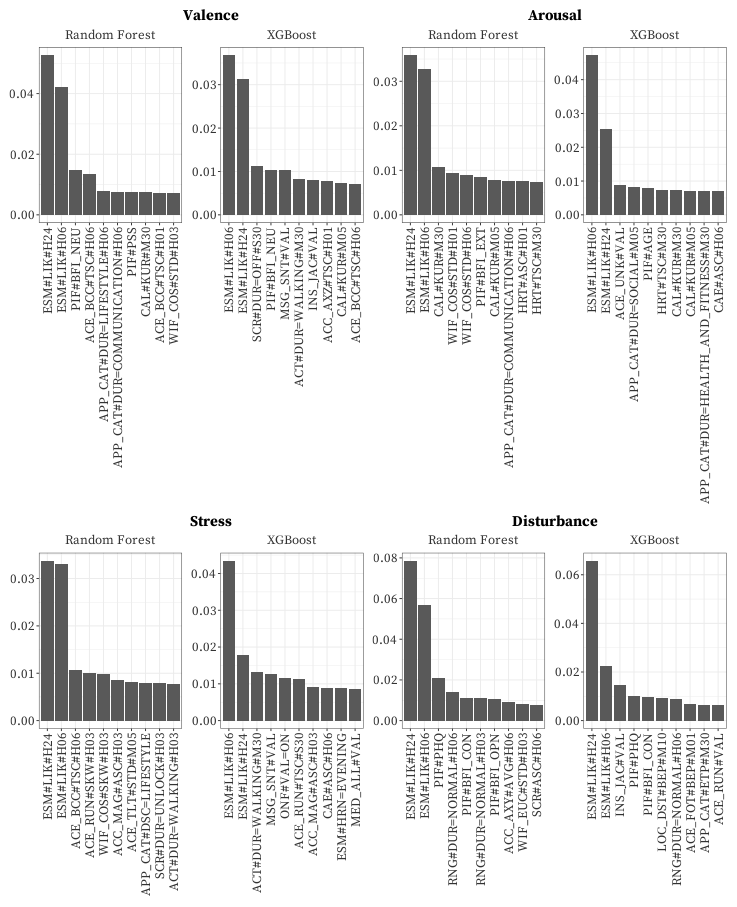

In [157]:
%%R -i IMPORTANCE_SUMMARY -w 26 -h 32 -u cm

plots <- list()

for (l in c('valence', 'arousal', 'stress', 'disturbance')) {
    data <- IMPORTANCE_SUMMARY %>% filter(
        (label == l)
    )

    p_label <- ggplot() + geom_text(
        aes(x=.5, y=.5),
        label=str_to_title(l), 
        family='ssp', 
        fontface='bold',
        size=4
    ) + theme_void()

    p_rf <- ggplot(
        data %>% filter(alg == 'rf_os') %>% top_n(n=10, wt=importance),
        aes(x=reorder(feature, -importance), y=importance),
    ) + geom_col(
    ) + THEME_DEFAULT + theme(
        axis.text.x=element_text(angle=90, size=10, hjust=1, vjust=.5),
        axis.title.x=element_blank(),
        axis.title.y=element_blank()
    ) + labs(
        subtitle='Random Forest'
    )
    
    p_xgb <- ggplot(
        data %>% filter(alg == 'xgb_os') %>% top_n(n=10, wt=importance),
        aes(x=reorder(feature, -importance), y=importance),
    ) + geom_col(
    ) + THEME_DEFAULT + theme(
        axis.text.x=element_text(angle=90, size=10, hjust=1, vjust=.5),
        axis.title.x=element_blank(),
        axis.title.y=element_blank()
    ) + labs(
        subtitle='XGBoost'
    )
    
    plots[[paste(l, 'label', sep='_')]] <- p_label
    plots[[paste(l, 'rf', sep='_')]] <- p_rf
    plots[[paste(l, 'xgb', sep='_')]] <- p_xgb
}

p <- plots$valence_label + plots$arousal_label
p <- p / (plots$valence_rf | plots$valence_xgb | plots$arousal_rf | plots$arousal_xgb)
p <- p / (plots$stress_label + plots$disturbance_label)
p <- p / (plots$stress_rf | plots$stress_xgb | plots$disturbance_rf | plots$disturbance_xgb)

p <- p + plot_layout(
    heights=c(1.1, 10, 1.1, 10)
)

ggsave(paste('./fig/imp.pdf'), plot=p, width=26, height=32, unit='cm', device=cairo_pdf)
print(p)
